# Neural Machine Translation with Attention Model

## 1. Introduction

We will build a Neural Machine Translation (NMT) model to translate human readable dates ("25th of June, 2009") into machine readable dates ("2009-06-25"). We will do this using an attention model, one of the most sophisticated sequence to sequence models.

The model we will build here could be used to translate from one language to another, such as translating from English to Hindi. However, language translation requires massive datasets and usually takes days of training on GPUs. To give us a place to experiment with these models even without using massive datasets, we will instead use a simpler "date translation" task. 

The network will input a date written in a variety of possible formats (*e.g. "the 29th of August 1958", "03/30/1968", "24 JUNE 1987"*) and translate them into standardized, machine readable dates (*e.g. "1958-08-29", "1968-03-30", "1987-06-24"*). We will have the network learn to output dates in the common machine-readable format YYYY-MM-DD.

**LSTM**: Long Short-Term Memory unit. The output of an LSTM cell is called the hidden state. Each LSTM cell retains an internal state that is not output, called the cell state, or c.

In [1]:
!pip install faker # install package on google colab

     |████████████████████████████████| 880kB 3.4MB/s 


In [2]:
%matplotlib inline
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import matplotlib.pyplot as plt
import numpy as np
from datetime import date
import random
from tqdm import tqdm
import pydot
from IPython.display import SVG
from faker import Faker # Faker is a Python package that generates fake data
from babel.dates import format_date # for working with date and time information
from pprint import pprint

import keras.backend as K
from keras.utils import to_categorical
from keras.layers import RepeatVector, Concatenate, Dense, Activation, Dot, Input 
from keras.layers import LSTM, Bidirectional
from keras.models import Model
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [0]:
Tx = 30 # maximum length of the human readable date
Ty = 10 # maximum length of machine readable date (YYYY-MM-DD)
m = 40000 # number of training examples to be generated

n_a = 32 # dimension of the hidden state vector for the Bi-LSTM
n_s = 64 # dimension of the hidden state vector for the post-attention LSTM

## 2. Dataset Generation and Pre-Processing

We will train the model on a dataset of m human readable dates and output their equivalent, standardized, machine readable dates.

We will use Tx=30 (which we assume is the maximum length of the human readable date; if we get a longer input, we would have to truncate it) and Ty=10 (since "YYYY-MM-DD" is 10 characters long). 

### 2.1 Dataset Generation

Let's take a look at what different formats we will produce.

In [4]:
# show the meaning of different format names

formats = ['short', 'EEE', 'EEEE', 'd', 'dd', 'MM', 'MMM', 'MMMM', 'YY', 'YYYY']
dt = date(2018, 8, 8)
for f in formats:
    print(f + ': ', end = '')
    human_readable = format_date(dt, format = f, locale = 'en_US')
    print(human_readable, end = '')
    print()    

short: 8/8/18
EEE: Wed
EEEE: Wednesday
d: 8
dd: 08
MM: 08
MMM: Aug
MMMM: August
YY: 18
YYYY: 2018


Let's create our datesets.

In [5]:
fake = Faker()
# Calling the same methods with the same version of faker and seed produces the same results.
fake.seed(12345)
random.seed(12345)

FORMATS_DM = [' d MMM ', ' d MMMM ', ' dd MMM ', ' dd MMMM ', 
              ' MMM d ', ' MMMM d ', ' MMM dd ', ' MMMM dd ',]
FORMATS_DMY = [i + 'YYYY' for i in FORMATS_DM] + [i + 'YY' for i in FORMATS_DM]
FORMATS_EDMY = ['EEE' + i for i in FORMATS_DMY] + ['EEEE' + i for i in FORMATS_DMY]
FORMATS = ['short'] + FORMATS_DMY + FORMATS_EDMY + ['MM.dd.YY', 'MM.dd.YYYY']
print('The number of different human-readable formats we will create: ' + str(len(FORMATS)))

The number of different human-readable formats we will create: 51


In [0]:
# function to generate a random date 

def generate_date():
    """
    Generate a fake date
    
    Returns: a tuple including human readable string, machine readable string ('YYYY-MM-DD'), 
    and the corresponding python datetime.date object
    
    Note that the human readable string is converted to lower case with ',' removed.
    """
    
    # get a fake date object
    dt = fake.date_object() # returns a python datetime.date object
    
    try:
        human_readable = format_date(dt, format = random.choice(FORMATS), locale = 'en_US')
        human_readable = human_readable.lower()
        human_readable = human_readable.replace(',', '')
        # Return a string representing the date in ISO 8601 format, ‘YYYY-MM-DD’. 
        machine_readable = dt.isoformat()
    except AttributeError as e:
        return None, None, None
    
    return human_readable, machine_readable, dt

In [0]:
# function to generate datasets

def generate_dataset(m):
    """
    Generate a dataset of m examples and volcabularies
    
    Arguments:
    m: number of examples
    
    Returns:
    dataset: a list of m tuples of (human readable date, machine readable date).
    human_vocab: a python dictionary mapping all characters used in the human readable dates to an integer-valued index.
    machine_vocab: a python dictionary mapping all characters used in machine readable dates to an integer-valued index. 
        These indices are not necessarily consistent with human_vocab.
    inv_machine_vocab: the inverse dictionary of machine_vocab, mapping from indices back to characters.
    """
        
    human_set = set() # store all characters used in the human readable dates
    machine_set = set() # store all characters used in the machine readable dates
    
    dataset = []
    
    for i in tqdm(range(m)):
        human_readable, machine_readable, _ = generate_date()
        if human_readable is not None:
            dataset.append((human_readable, machine_readable))
            human_set.update(tuple(human_readable))
            machine_set.update(tuple(machine_readable))
            
    # add '<unk>' and '<pad>' for unknown and padded characters
    human_vocab = dict(zip(sorted(human_set) + ['<unk>', '<pad>'], list(range(len(human_set) + 2)))) 
    machine_vocab = dict(zip(sorted(machine_set), list(range(len(machine_set))))) 
    inv_machine_vocab = {v:k for k,v in machine_vocab.items()}
    
    return dataset, human_vocab, machine_vocab, inv_machine_vocab

In [8]:
# generate m datasets

dataset, human_vocab, machine_vocab, inv_machine_vocab = generate_dataset(m)

100%|██████████| 40000/40000 [00:01<00:00, 27818.00it/s]


In [9]:
# The pprint module provides a capability to “pretty-print” arbitrary Python data structures.
print('Data set examples:')
pprint(dataset[:20])

Data set examples:
[('sat 9 may 98', '1998-05-09'),
 ('thursday september 10 70', '1970-09-10'),
 ('4/28/90', '1990-04-28'),
 ('thu 26 jan 1995', '1995-01-26'),
 ('mon mar 07 1983', '1983-03-07'),
 (' 22 may 88', '1988-05-22'),
 ('tue 8 jul 2008', '2008-07-08'),
 ('wednesday 08 september 1999', '1999-09-08'),
 ('thu 01 jan 81', '1981-01-01'),
 (' 22 may 95', '1995-05-22'),
 ('fri jun 16 1978', '1978-06-16'),
 (' jun 18 1999', '1999-06-18'),
 ('thu 08 oct 87', '1987-10-08'),
 (' april 01 08', '2008-04-01'),
 ('thursday 06 sep 2012', '2012-09-06'),
 ('thursday november 12 1981', '1981-11-12'),
 (' 19 aug 11', '2011-08-19'),
 ('saturday aug 25 2007', '2007-08-25'),
 ('saturday 18 sep 1982', '1982-09-18'),
 (' 25 feb 94', '1994-02-25')]


In [10]:
print('\nhuman_vocab:')
print(human_vocab)
print('\nmachine_vocab:')
print(machine_vocab)
print('\ninv_machine_vocab:')
print(inv_machine_vocab)


human_vocab:
{' ': 0, '.': 1, '/': 2, '0': 3, '1': 4, '2': 5, '3': 6, '4': 7, '5': 8, '6': 9, '7': 10, '8': 11, '9': 12, 'a': 13, 'b': 14, 'c': 15, 'd': 16, 'e': 17, 'f': 18, 'g': 19, 'h': 20, 'i': 21, 'j': 22, 'l': 23, 'm': 24, 'n': 25, 'o': 26, 'p': 27, 'r': 28, 's': 29, 't': 30, 'u': 31, 'v': 32, 'w': 33, 'y': 34, '<unk>': 35, '<pad>': 36}

machine_vocab:
{'-': 0, '0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6, '6': 7, '7': 8, '8': 9, '9': 10}

inv_machine_vocab:
{0: '-', 1: '0', 2: '1', 3: '2', 4: '3', 5: '4', 6: '5', 7: '6', 8: '7', 9: '8', 10: '9'}


### 2.2 Data Pre-Processing

Let's preprocess the data and map the raw text data into the index values.

We will have:
- `X`: a processed version of the human readable dates in the training set, where each character is replaced by an index mapped to the character via `human_vocab`. Each date is further padded to $T_x$ values with a special character (< pad >). `X.shape = (m, Tx)`
- `Y`: a processed version of the machine readable dates in the training set, where each character is replaced by the index it is mapped to in `machine_vocab`. `Y.shape = (m, Ty)`. 
- `Xoh`: one-hot version of `X`, the "1" entry's index is mapped to the character thanks to `human_vocab`. `Xoh.shape = (m, Tx, len(human_vocab))`
- `Yoh`: one-hot version of `Y`, the "1" entry's index is mapped to the character thanks to `machine_vocab`. `Yoh.shape = (m, Tx, len(machine_vocab))`. Here, `len(machine_vocab) = 11` since there are 11 characters ('-' as well as 0-9). 


In [0]:
def string_to_ints(string, length, vocab):
    """
    Convert the characters in string into a list of integer indices based on the dictionary
    
    Argument:
    string: input string, e.g., 'Mon 3 Sep 2018'
    length: the number of time steps, which determines if the input will be padded or cut
    vocab: vocabulary, dictionary used to convert character to index
    
    Returns:
    output: list of integers representing the indices of string's characters according to vocab
    """
    
    if len(string) > length:
        string = string[:length]
        
    output = list(map(lambda x : vocab.get(x, vocab.get('<unk>')), tuple(string)))
    
    if len(string) < length:
        output += [vocab['<pad>']] * (length - len(string))
        
    return output

In [0]:
def preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty):
    """
    Convert the characters in strings into one-hot vectors
    """
    
    human_readable, machine_readable = zip(*dataset) 
    
    human_readable_ints = np.array([string_to_ints(string, Tx, human_vocab) for string in human_readable]) #(m, Tx)
    machine_readable_ints = np.array([string_to_ints(string, Ty, machine_vocab) for string in machine_readable]) #(m, Ty)
    
    # map() applies the to_categorical() function to each of the m items.
    human_readable_oh = np.array(list(map(lambda x : to_categorical(x, num_classes = len(human_vocab)), 
                                          human_readable_ints))) 
    machine_readable_oh = np.array(list(map(lambda x : to_categorical(x, num_classes = len(machine_vocab)), 
                                            machine_readable_ints)))
    
    return human_readable_ints, machine_readable_ints, human_readable_oh, machine_readable_oh 

In [0]:
X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)

In [14]:
print('X.shape (human readable): ' + str(X.shape))
print('Y.shape (machine readable): ' + str(Y.shape))
print('Xoh.shape (one-hot): ' + str(Xoh.shape))
print('Yoh.shape (one-hot): ' + str(Yoh.shape))

index = 10
print('\nExample ' + str(index) + ': ')
print('human readable date: ' + str(dataset[index][0]))
print('machine readable date: ' + str(dataset[index][1]))
print('human readable date after processing (indices):')
print(X[index])
print('machine readable date after processing (indices):')
print(Y[index])
print('human readable date after processing (one hot): ')
print(Xoh[index])
print('machine readable date after processing (one hot):')
print(Yoh[index])

X.shape (human readable): (40000, 30)
Y.shape (machine readable): (40000, 10)
Xoh.shape (one-hot): (40000, 30, 37)
Yoh.shape (one-hot): (40000, 10, 11)

Example 10: 
human readable date: fri jun 16 1978
machine readable date: 1978-06-16
human readable date after processing (indices):
[18 28 21  0 22 31 25  0  4  9  0  4 12 10 11 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36]
machine readable date after processing (indices):
[ 2 10  8  9  0  1  7  0  2  7]
human readable date after processing (one hot): 
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
machine readable date after processing (one hot):
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

## 3. Attention Model

If we had to translate a book's paragraph from French to English, we would not read the whole paragraph, then close the book and translate. Even during the translation process, we would read/re-read and focus on the parts of the French paragraph corresponding to the parts of the English we are writing down. 

The attention mechanism tells a Neural Machine Translation model where it should pay attention to at any step. 

Here is a figure about how the model works. The diagram on the left shows the attention model. The diagram on the right shows what one "Attention" step does to calculate the attention variables $\alpha^{\langle t, t' \rangle}$, which are used to compute the context variable $context^{\langle t \rangle}$ for each timestep in the output ($t=1, \ldots, T_y$). 

<table>
<td> 
<img src="images/attn_model.png" style="width:500;height:500px;"> <br>
</td> 
<td> 
<img src="images/attn_mechanism.png" style="width:500;height:500px;"> <br>
</td> 
</table>

Here are some properties of the model: 

- There are two separate LSTMs in this model (see diagram on the left). Because the one at the bottom of the picture is a Bi-directional LSTM and comes *before* the attention mechanism, we will call it *pre-attention* Bi-LSTM. The LSTM at the top of the diagram comes *after* the attention mechanism, so we will call it the *post-attention* LSTM. The pre-attention Bi-LSTM goes through $T_x$ time steps; the post-attention LSTM goes through $T_y$ time steps. 

- The post-attention LSTM passes $s^{\langle t \rangle}, c^{\langle t \rangle}$ from one time step to the next. Since we are using an LSTM here, the LSTM has both the output activation $s^{\langle t\rangle}$ and the hidden cell state $c^{\langle t\rangle}$. However, unlike text generation examples, in this model the post-activation LSTM at time $t$ will not take the specific generated $y^{\langle t-1 \rangle}$ as input; it only takes $s^{\langle t\rangle}$ and $c^{\langle t\rangle}$ as input. We have designed the model this way, because (unlike language generation where adjacent characters are highly correlated) there isn't as strong a dependency between the previous character and the next character in a YYYY-MM-DD date. 

- We use $a^{\langle t \rangle} = [\overrightarrow{a}^{\langle t \rangle}; \overleftarrow{a}^{\langle t \rangle}]$ to represent the concatenation of the activations of both the forward-direction and backward-directions of the pre-attention Bi-LSTM. 

- The diagram on the right uses a `RepeatVector` node to copy $s^{\langle t-1 \rangle}$'s value $T_x$ times, and then `Concatenation` to concatenate $s^{\langle t-1 \rangle}$ and $a^{\langle t \rangle}$ to compute $e^{\langle t, t' \rangle}$, which is then passed through a softmax to compute $\alpha^{\langle t, t' \rangle}$. 

**1) `one_step_attention()`**: At step $t$, given all the hidden states of the Bi-LSTM ($[a^{<1>},a^{<2>}, ..., a^{<T_x>}]$) and the previous hidden state of the second LSTM ($s^{<t-1>}$), `one_step_attention()` will compute the attention weights ($[\alpha^{<t,1>},\alpha^{<t,2>}, ..., \alpha^{<t,T_x>}]$) and output the context vector:
$$context^{<t>} = \sum_{t' = 0}^{T_x} \alpha^{<t,t'>}a^{<t'>}\tag{1}$$ 

We will call the layers in `one_step_attention()` $T_y$ times using a for-loop, and it is important that all dense layers (to calculate attention weights) have the same weights. I.e., it should not re-initiaiize the weights every time. In other words, all $T_y$ steps should have shared weights. Here's how you can implement layers with shareable weights in Keras:
1. Define the layer objects (as global variables).
2. Call these objects when propagating the input.

See one_step_attention() below to understand the dimensions and axes.

Note: https://jamesmccaffrey.wordpress.com/2016/03/04/the-max-trick-when-computing-softmax/ <br>
In practice, calculating softmax values can go wrong if any x value is very large — the exp() of even a moderate-magnitude positive number can be astronomically huge. A trick to avoid this computation problem is subtract the largest x value from each x value.

In [0]:
# our customized softmax function
# The dimension of input x will be (m, Tx, 1), and softmax will be applied to axis = 1

def softmax(x, axis = 1):
    """
    compute softmax activation
    
    Arguments:
    x: input tensor
    axis: integer, axis along which the softmax normalization is applied
    
    Return: tensor, output of softmax activation, with the same dimension as x
    """
    
    max_val = K.max(x, axis = axis, keepdims = True)
    e = K.exp(x - max_val)
    s = K.sum(e, axis = axis, keepdims = True)
    return e / s

In [0]:
# define shared layers as global variables

# Dense(): input shape: (batch_size, ..., input_dim), output shape: (batch_size, ..., units)
densor1 = Dense(units = 10, activation = 'tanh', name = 'context_dense1')
densor2 = Dense(units = 1, name = 'context_dense2')
repeator = RepeatVector(Tx, name = 'repeat_s')
concatenator = Concatenate(axis = -1, name = 'concatenate_s_a')
activator = Activation(softmax, name = 'attention_weights') # use our customized softmax function above.
dotor = Dot(axes = 1, name = 'context')

In [0]:
def one_step_attention(a, s_prev):
    """
    Compute the context vector, using dot product of alpha<t, t'> and a<t'> 
    
    Argument:
    a: all of the hidden state output a<t'> of the Bi-LSTM, numpy array with dimension of (m, Tx, 2 * n_a)
    s_prev: previous hiddent state s<t-1> of the post-attention LSTM, numpy array with dimension of (m, n_s)
    
    Returns:
    context: context vector, weighted sum of a<t'>, input of post-attention LSTM cell, with dimension of (m, 1, 2 * n_a)
    """
    
    # repeat s_prev so the shape is (m, Tx, n_s), so that we can concatenate it with "a"
    s_prev = repeator(s_prev)
    # concatenate a and s_prev on the last axis, so the shape is (m, Tx, 2 * n_a + n_s)
    concat = concatenator([a, s_prev])
    # propagate concat through a small fully-connected neural network to compute the "intermediate energies" variable e, 
    # with dimension (m, Tx, 10)
    e = densor1(concat)
    # propagate "e" through a small fully-connected neural network to compute the "energies" variable energies, 
    # with dimension (m, Tx, 1)
    energies = densor2(e)
    # use softmax activation on "energies" to compute the attention weights "alphas", with dimension of (m, Tx, 1)
    alphas = activator(energies)
    # compute the context vector, with the dimension of (m, 1, 2 * n_a)
    # dot product of (m, Tx, 1) and (m, Tx, 2 * n_a), along axis = 1, is (m, 1, 2 * n_a). 
    # Remember that dot product of (batch_size, n) and (batch_size, n) is (batch_size, 1).
    # each row t' of alphas(m, Tx, 1) is alpha<t, t'> (1, 1), and each row of a(m, Tx, 2*n_a) is a<t'> (1, 2*n_a), 
    # apply dot product will multiply each of the 2*n_a items in a<t'> by alpha<t, t'>, and then sum over Tx 
    context = dotor([alphas, a])
    
    return context

**2) `model()`**: Implements the entire model. It first runs the input through a Bi-LSTM to get back $[a^{<1>},a^{<2>}, ..., a^{<T_x>}]$. Then, it calls `one_step_attention()` $T_y$ times (`for` loop). At each iteration of this loop, it gives the computed context vector $c^{<t>}$ to the second LSTM, and runs the output of the LSTM through a dense layer with softmax activation to generate a prediction $\hat{y}^{<t>}$. 

Again, we have defined global layers that will share weights to be used in `model()`.

**return_state and return_sequences in LSTM():**<br>
https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/<br>
return_state argument in the LSTM layer will provide access to not only the hidden state output but also the cell state.

If we set return_sequences = True, return_state = False, it will return:
- a sequence of timesteps values, one hidden state output for each input time step for the single LSTM cell in the layer.

If we set return_sequences = False, return_state = True, it will return 3 arrays:
- The LSTM hidden state output for the last input time step.
- The LSTM hidden state output for the last input time step (again).
- The LSTM cell state for the last input time step.

If we set return_sequences = True, return_state = True, it will return 3 arrays:
- The LSTM hidden state output for each input time step.
- The LSTM hidden state output for the last input time step.
- The LSTM cell state for the last input time step.

In [0]:
post_attention_LSTM = LSTM(units = n_s, return_state = True, name = 'post_attention_LSTM_cell')
output_layer = Dense(len(machine_vocab), activation = softmax, name = 'post_attention_LSTM_dense_softmax')

We will carry out the following steps: 

1. Propagate the input into a [Bidirectional](https://keras.io/layers/wrappers/#bidirectional) [LSTM](https://keras.io/layers/recurrent/#lstm)
2. Iterate for $t = 0, \dots, T_y-1$: 
    1. Call `one_step_attention()` on $[\alpha^{<t,1>},\alpha^{<t,2>}, ..., \alpha^{<t,T_x>}]$ and $s^{<t-1>}$ to get the context vector $context^{<t>}$.
    2. Give $context^{<t>}$ to the post-attention LSTM cell. Remember pass in the previous hidden-state $s^{\langle t-1\rangle}$ and cell-states $c^{\langle t-1\rangle}$ of this LSTM using `initial_state= [previous hidden state, previous cell state]`. Get back the new hidden state $s^{<t>}$ and the new cell state $c^{<t>}$.
    3. Apply a softmax layer to $s^{<t>}$, get the output. 
    4. Save the output by adding it to the list of outputs.

3. Create our Keras model instance, it should have three inputs ("inputs", $s^{<0>}$ and $c^{<0>}$) and output the list of "outputs".

In [0]:
def nmt_model(Tx, Ty, n_a, n_s, input_one_hot_size):
    """
    complete neural machine translation model
    
    Arguments:
    Tx: length of the input sequence
    Ty: length of the output sequence
    n_a: dimension of the hidden state vector for the Bi-LSTM
    n_s: dimension of the hidden state vector and cell state vector for the post-attention LSTM
    input_one_hot_size: length of the one-hot vector of the input
    
    Returns:
    model: Keras model instance
    """
    # input layer, the batch dimension is not included in the shape.
    X = Input(shape = (Tx, input_one_hot_size), name = 'input') # shape: (m, Tx, len(human_vocab))
    # s0 and c0 are initial hidden and cell states for the post-attention LSTM (decoder), 
    # which are vectors with dimension of (n_s, )
    s0 = Input(shape = (n_s, ), name = 's0') # shape: (m, n_s)
    c0 = Input(shape = (n_s, ), name = 'c0') # shape: (m, n_s)
    s = s0
    c = c0
    
    # store the outputs (y hat)
    outputs = []
    
    # pre-attention Bi-LSTM
    a = Bidirectional(LSTM(units = n_a, return_sequences = True), name = 'Bi-LSTM')(X) # output shape: (m, Tx, 2 * n_a)
    
    # iterate for Ty step
    for t in range(Ty):
        # Call one_step_attention() to get the context vector.
        context = one_step_attention(a, s) # output shape: (m, 1, 2 * n_a)
        # Give context vector to the post-attention LSTM cell. Get back the new hidden state s<t>  
        # and the new cell state c<t>.
        s, _, c = post_attention_LSTM(context, initial_state = [s, c]) # both ouput shapes: (m, n_s)
        # Apply a dense and softmax layer to s<t>, get the output.
        out = output_layer(s) # output shape: (m, len(machine_vocab))
        outputs.append(out) 
    
    # after Ty iterations, outputs is a list of Ty Numpy arrays, each with shape (m, len(machine_vocab))
    model = Model(inputs = [X, s0, c0], outputs = outputs)
    
    return model

In [0]:
model = nmt_model(Tx, Ty, n_a, n_s, len(human_vocab))

In [21]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 30, 37)       0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 (None, 64)           0                                            
__________________________________________________________________________________________________
Bi-LSTM (Bidirectional)         (None, 30, 64)       17920       input[0][0]                      
__________________________________________________________________________________________________
repeat_s (RepeatVector)         (None, 30, 64)       0           s0[0][0]                         
                                                                 post_attention_LSTM_cell[0][0]   
          

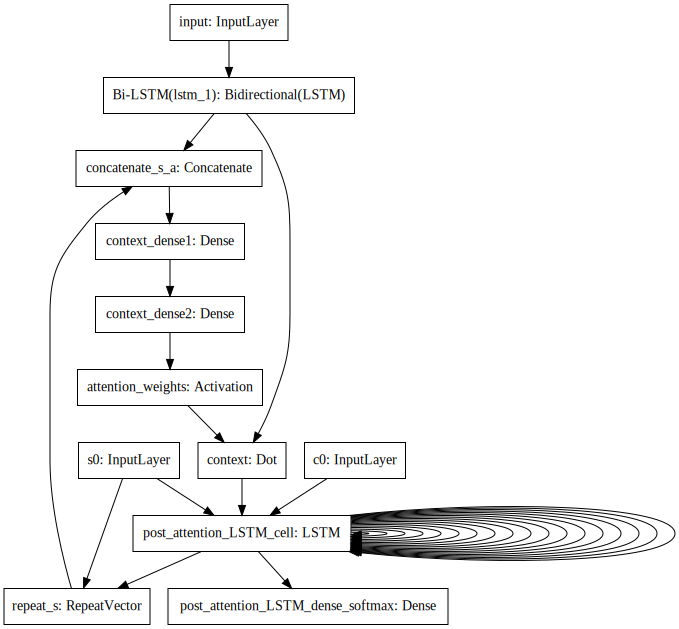

In [22]:
# plot the model schematics
SVG(model_to_dot(model).create(prog='dot', format='svg'))

## 4. Model Training and Evaluation

The last step is to define all inputs and outputs to fit the model:
- We already have X of shape $(m, Tx)$ containing the training examples.
- We need to create `s0` and `c0` to initialize our `post_attention_LSTM` with 0s.
- Given the `model()`, we need the "outputs" to be a list of Ty elements of shape (m, len(machine_vocab)).

In [0]:
# compile the model

opt = Adam(lr = 0.005, beta_1 = 0.9, beta_2 = 0.999, decay = 0.01)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [0]:
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))

train_x = Xoh
# Yoh is (m, Ty, len(machine_vocab)), swap axis 0 and 1 so it is (Ty, m, len(machine_vocab))
# convert the first axis to list, to match the output format (a list of Ty arrays)
train_y = list(Yoh.swapaxes(0, 1)) 

In [25]:
history = model.fit(x = [train_x, s0, c0], y = train_y, batch_size = 200, epochs = 200, verbose = 2)

Epoch 1/200
 - 38s - loss: 12.1342 - post_attention_LSTM_dense_softmax_loss: 2.0468 - post_attention_LSTM_dense_softmax_acc: 0.6329 - post_attention_LSTM_dense_softmax_acc_1: 0.7600 - post_attention_LSTM_dense_softmax_acc_2: 0.4589 - post_attention_LSTM_dense_softmax_acc_3: 0.1943 - post_attention_LSTM_dense_softmax_acc_4: 0.9833 - post_attention_LSTM_dense_softmax_acc_5: 0.6526 - post_attention_LSTM_dense_softmax_acc_6: 0.2423 - post_attention_LSTM_dense_softmax_acc_7: 0.9884 - post_attention_LSTM_dense_softmax_acc_8: 0.4941 - post_attention_LSTM_dense_softmax_acc_9: 0.2654
Epoch 2/200
 - 28s - loss: 4.8067 - post_attention_LSTM_dense_softmax_loss: 1.0386 - post_attention_LSTM_dense_softmax_acc: 0.9416 - post_attention_LSTM_dense_softmax_acc_1: 0.9476 - post_attention_LSTM_dense_softmax_acc_2: 0.7817 - post_attention_LSTM_dense_softmax_acc_3: 0.6483 - post_attention_LSTM_dense_softmax_acc_4: 1.0000 - post_attention_LSTM_dense_softmax_acc_5: 0.9810 - post_attention_LSTM_dense_softmax_a

In [26]:
# since y is a list of Ty Numpy arrays, which means the model has multiple 
# outputs, the returned value is also a list of Ty scalars.
s_init = np.zeros((m, n_s))
c_init = np.zeros((m, n_s))
preds = model.evaluate(x = [train_x, s_init, c_init], y = train_y) 

40000/40000 [==============================] - 69s 2ms/step


In [27]:
# print the accuracy for each of the Ty time steps
print("Training Accuracy:")
print(preds[11:]) # check model.metrics_names for the meaning of each value in preds 

Training Accuracy:
[0.999925, 0.999875, 0.9996, 0.99595, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


## 5. Model Testing

We generate some random data and test the model accuracy.

In [0]:
# function to test examples

def test(examples):
    """
    Test some examples.
    
    Argument:
    examples: a list of tuples of (human readable date, machine readable date).
    """
    
    human_readable, machine_readable = zip(*examples)
    m = len(human_readable)
    s_initial = np.zeros((m, n_s))
    c_initial = np.zeros((m, n_s))
    predictions = [] # the predicted machine readable dates
    
    for example in human_readable:
        example_index = string_to_ints(example.lower(), Tx, human_vocab)
        example_oh = np.array(list(map(lambda x : to_categorical(x, num_classes = len(human_vocab)), example_index)))
        example_oh = np.expand_dims(example_oh, 0) # insert axis = 0, so the dimension is (1, Tx, len(human_vocab))
        prediction = model.predict(x = [example_oh, s_initial, c_initial])
        prediction = np.argmax(prediction, axis = -1)
        prediction = [inv_machine_vocab[i] for i in prediction.flatten().tolist()]
        prediction = ''.join(prediction)
        predictions.append(prediction)
    
    y = np.array(machine_readable)
    y_pred = np.array(predictions)
    acc = np.sum(y == y_pred) / len(y)
    print('Test accuracy: ' + str(acc))
    
    # show 10 prediction examples
    print('\nSome translation results:')
    for i in range(10):
        print(human_readable[i] + ' ---> ' + predictions[i])

In [41]:
examples, _, _, _ = generate_dataset(1000)
test(examples)

100%|██████████| 1000/1000 [00:00<00:00, 20870.30it/s]


Test accuracy: 0.996

Some translation results:
 may 26 10 ---> 2010-05-26
 22 nov 1983 ---> 1983-11-22
1/28/78 ---> 1978-01-28
wednesday sep 04 13 ---> 2013-09-04
sun 31 may 09 ---> 2009-05-31
wed 18 feb 81 ---> 1981-02-18
tuesday 02 september 80 ---> 1980-09-02
monday september 11 78 ---> 1978-09-11
thu 12 jul 01 ---> 2001-07-12
tuesday july 10 79 ---> 1979-07-10


## 6. Visualizing Attention

One advantage of the attention model is that each part of the output (say the month) knows it needs to depend only on a small part of the input (the characters in the input giving the month). We can  visualize what part of the output is looking at what part of the input.

We'll propagate an example through the network, then visualize the values of $\alpha^{\langle t, t' \rangle}$. 

In [0]:
def plot_attention_map(model, Tx, Ty, model_layer, human_vocab, inv_machine_vocab, example):
    """
    Visualize the attention values. model_layer is the layer# of the model for outputting attention weights.
    """
    
    attention_map = np.zeros((Ty, Tx)) # attantion map matrix to be plotted
    s_initial = np.zeros((1, n_s))
    c_initial = np.zeros((1, n_s))
    
    example_index = string_to_ints(example.lower(), Tx, human_vocab)
    example_oh = np.array(list(map(lambda x : to_categorical(x, num_classes = len(human_vocab)), example_index)))
    example_oh = np.expand_dims(example_oh, 0) # insert axis = 0, so the dimension is (1, Tx, len(human_vocab))
   
    layer = model.layers[model_layer]
    func = K.function(model.inputs, [layer.get_output_at(t) for t in range(Ty)])
    attention_weights = func([example_oh, s_initial, c_initial]) # get attention weights, shape (Ty, 1, Tx, 1)
    
    # fill in attention_map
    for t in range(Ty):
        for t_prime in range(Tx):
            attention_map[t][t_prime] = attention_weights[t][0][t_prime][0]
    
    # get the predicted string, as a list of characters
    prediction = model.predict(x = [example_oh, s_initial, c_initial])
    prediction = np.argmax(prediction, axis = -1)
    prediction = [inv_machine_vocab[i] for i in prediction.flatten().tolist()]
    
    # lengths of the input and output strings to be plotted
    out_length = len(prediction)
    in_length = len(example)
    
    # prepare the figure
    figure = plt.figure(figsize = (8, 8.5))
    ax = figure.add_subplot(1, 1, 1)
    img = ax.imshow(attention_map, interpolation = 'nearest', cmap = 'Blues')
    ax.set_yticks(range(out_length))
    ax.set_yticklabels(prediction)
    ax.set_ylabel('Output Sequence')
    ax.set_xticks(range(in_length))
    ax.set_xticklabels(example, rotation = 45)
    ax.set_xlabel('Input Sequence')
    ax.grid()
    # add colorbar
    cbaraxes = figure.add_axes([0.13, 0.28, 0.75, 0.03]) # [left, bottom, width, height] 
    figure.colorbar(mappable = img, cax = cbaraxes, orientation = 'horizontal')
    cbaraxes.set_xlabel('color bar')
    
    print('Input: ' + example)
    print('Output: ' + ''.join(prediction))
    
    return attention_map

Input: Wednesday Jul 9 2009
Output: 2009-07-09


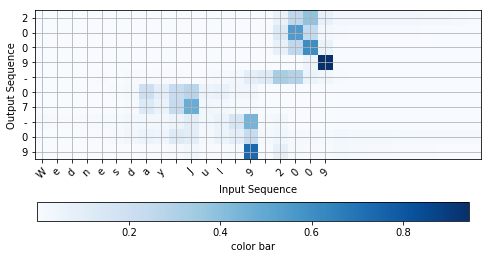

In [51]:
attention_map = plot_attention_map(model, Tx, Ty, 7, human_vocab, inv_machine_vocab, 'Wednesday Jul 9 2009')

Input: 10/15/1988
Output: 1988-10-15


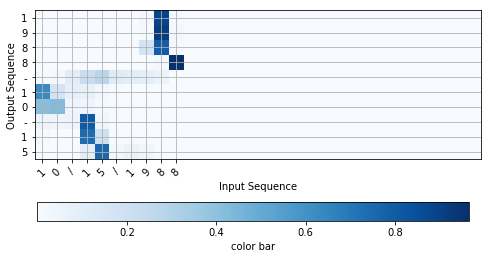

In [52]:
attention_map = plot_attention_map(model, Tx, Ty, 7, human_vocab, inv_machine_vocab, '10/15/1988')

Input: may 26 10
Output: 2010-05-26


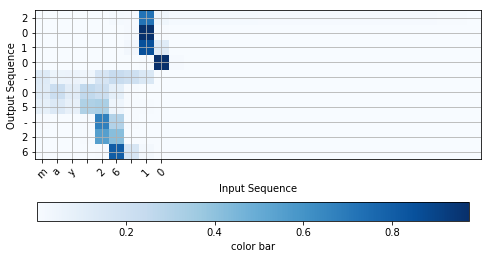

In [53]:
attention_map = plot_attention_map(model, Tx, Ty, 7, human_vocab, inv_machine_vocab, 'may 26 10')

Input: 10.15.88
Output: 1988-10-15


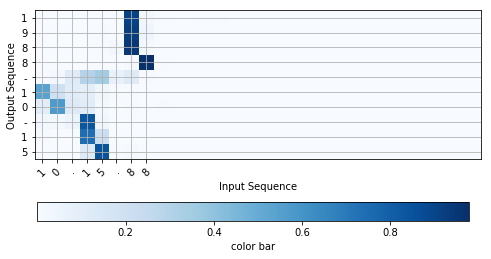

In [54]:
attention_map = plot_attention_map(model, Tx, Ty, 7, human_vocab, inv_machine_vocab, '10.15.88')

## 7. Save Model

In [ ]:
model.save('nmt_model.h5')